<a href="https://colab.research.google.com/github/a-m-kacz/MLA/blob/main/lab3_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification using advanced CNNs
- we are going to use CIFAR-10 [dataset](https://www.cs.toronto.edu/~kriz/cifar.html) of 32x32 color images

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import numpy as np

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

model_args = {}
# we will use batch size of 64 in Stochastic Gradient Descent (SGD) optimization of the network
model_args['batch_size'] = 64 
# learning rate is how fast it will descend
model_args['lr'] = .05
# SGD momentum (default: .5) momentum is a moving average of gradients (it helps to keep direction) 
model_args['momentum'] = .9
# the number of epochs is the number of times you go through the full dataset
model_args['weight_decay'] = 5.e-4
model_args['epochs'] = 30

### Download CIFAR-10 dataset and define models
Similar as with MNIST we use torchvision to download the data

In [2]:
!rm -r ./data
# normalize dataset
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
#mean = [.5, .5, .5]
#std = [.5, .5, .5]
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean, std)])

cifar10_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# we divide this data into training and validation subsets
train_subset, validation_subset = torch.utils.data.random_split(cifar10_train, [40000, 10000])
test_subset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# subsample to speedup training (colab has notebook lifetime limit)
train_subset = torch.utils.data.Subset(train_subset, range(20000))
validation_subset = torch.utils.data.Subset(validation_subset, range(5000))
test_subset = torch.utils.data.Subset(test_subset, range(5000))

# define dataloaders
loader_kwargs = {'batch_size': model_args['batch_size'], 
                 'num_workers': 2, 
                 'pin_memory': True, 
                 'shuffle': True}
train_loader = torch.utils.data.DataLoader(train_subset, **loader_kwargs)
validation_loader = torch.utils.data.DataLoader(validation_subset, **loader_kwargs)
test_loader = torch.utils.data.DataLoader(test_subset, **loader_kwargs)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

rm: cannot remove './data': No such file or directory


100%|██████████| 170498071/170498071 [00:07<00:00, 23540997.29it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let's show some of the training images

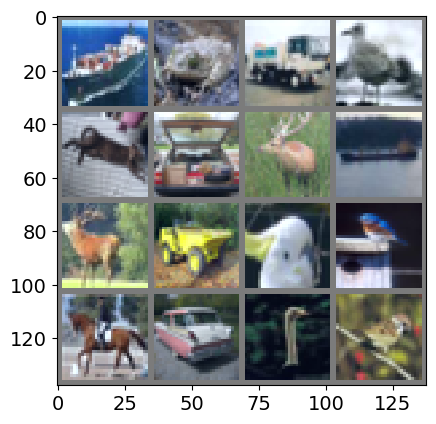

In [3]:
def imshow(img):
    npimg = img.numpy()*std[0]+mean[0] # this should be done for each channel separately ;)
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

# get some random training images
dataiter = iter(train_loader)
images, _ = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:16], nrow=4))


Now define CNN models
- VGG definition borrowed from *https://github.com/chengyangfu/pytorch-vgg-cifar10*


In [4]:
class SimpleCNN(nn.Module):
    '''
    simple CNN model
    '''
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 80)
        self.fc3 = nn.Linear(80, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class VGG(nn.Module):
    '''
    VGG model 
    '''
    def __init__(self, features):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, 10),
        )
        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, np.sqrt(2. / n))
                m.bias.data.zero_()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

vgg_cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
    'vgg22': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 256, 'M', 512, 512, 512, 512, 512, 'M', 512, 512, 512, 512, 512, 'M']
}

Define util methods

In [5]:
def train(model, device, train_loader, optimizer, criterion, epoch_number):
    model.train()
    train_loss = 0.
    # get subsequent batches over the data in a given epoch
    for batch_idx, (data, target) in enumerate(train_loader):
        # send data tensors to GPU (or CPU)
        data, target = data.to(device), target.to(device)
        # this will zero out the gradients for this batch
        optimizer.zero_grad()
        # this will execute the forward() function
        output = model(data)
        # calculate loss using c
        loss = criterion(output, target)
        # backpropagate the loss
        loss.backward()
        # update the model weights (with assumed learning rate)
        optimizer.step()
        train_loss += loss.item()
    print('Train Epoch: {}'.format(epoch_number))
    train_loss /= len(train_loader)
    print('\tTrain set: Average loss: {:.4f}'.format(train_loss))
    return train_loss
    
def test(model, device, test_loader, criterion, message=None):
    model.eval()
    test_loss = 0.
    correct = 0
    # this is just inference, we don't need to calculate gradients
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device) 
            output = model(data)
            # calculate and sum up batch loss
            test_loss += criterion(output, target) 
            # get the index of class with the max probability 
            prediction = output.argmax(dim=1)  
            #_, predicted = torch.max(outputs.data, axis=1)
            # item() returns value of the given tensor
            correct += prediction.eq(target).sum().item()
    test_loss /= len(test_loader)
    accuracy = correct / len(test_loader.dataset)
    if message is not None:
        print('\t{}: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
            message, test_loss, correct, len(test_loader.dataset), 100.*accuracy))
    return test_loss.cpu(), accuracy

def run_training(model, criterion, optimizer, no_epochs):
    train_loss = []
    validation_loss = []
    validation_accuracy = []
    test_accuracy = []
    for epoch_number in range(1, no_epochs+1):
        train_loss.append(train(model, device, train_loader, 
                                optimizer, criterion, epoch_number))
        val_loss, val_acc = test(model, device, validation_loader, 
                                criterion, 'Validation set')
        validation_loss.append(val_loss)
        validation_accuracy.append(val_acc)
        # we also collect test accuracies for every epoch
        _, test_acc = test(model, device, test_loader, criterion)
        test_accuracy.append(test_acc)
    # and select test accuracy for the best epoch (with the highest validation accuracy)
    best_accuracy = test_accuracy[np.argmax(validation_accuracy)]
    return train_loss, validation_loss, best_accuracy

def plot_loss(train_loss, validation_loss, title):
    plt.grid(True)
    plt.xlabel("subsequent epochs")
    plt.ylabel('average loss')
    plt.plot(range(1, len(train_loss)+1), train_loss, 'o-', label='training')
    plt.plot(range(1, len(validation_loss)+1), validation_loss, 'o-', label='validation')
    plt.legend()
    plt.title(title)
    plt.show()

### Do the experiments

Train Epoch: 1
	Train set: Average loss: 1.9307
	Validation set: Average loss: 1.7883, Accuracy: 1786/5000 (36%)
Train Epoch: 2
	Train set: Average loss: 1.7130
	Validation set: Average loss: 1.6206, Accuracy: 2106/5000 (42%)
Train Epoch: 3
	Train set: Average loss: 1.6354
	Validation set: Average loss: 1.6448, Accuracy: 2089/5000 (42%)
Train Epoch: 4
	Train set: Average loss: 1.5627
	Validation set: Average loss: 1.6121, Accuracy: 2156/5000 (43%)
Train Epoch: 5
	Train set: Average loss: 1.5106
	Validation set: Average loss: 1.6762, Accuracy: 2018/5000 (40%)
Train Epoch: 6
	Train set: Average loss: 1.4789
	Validation set: Average loss: 1.6219, Accuracy: 2140/5000 (43%)
Train Epoch: 7
	Train set: Average loss: 1.4645
	Validation set: Average loss: 1.6092, Accuracy: 2147/5000 (43%)
Train Epoch: 8
	Train set: Average loss: 1.4403
	Validation set: Average loss: 1.6572, Accuracy: 2124/5000 (42%)
Train Epoch: 9
	Train set: Average loss: 1.4316
	Validation set: Average loss: 1.6121, Accuracy:

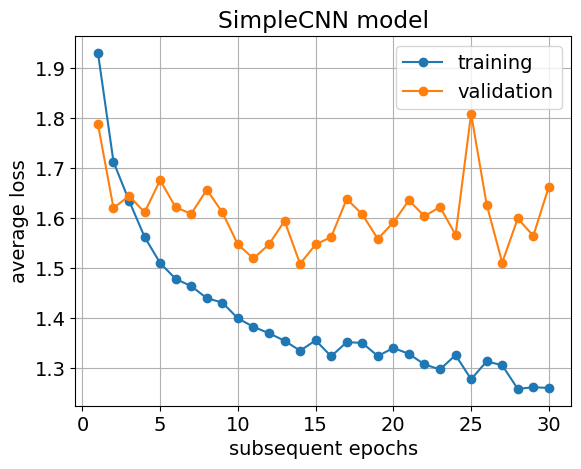

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=model_args['lr'], 
                      momentum=model_args['momentum'],
                      weight_decay=model_args['weight_decay'])
no_epochs = model_args['epochs']

train_loss, val_loss, best_accuracy = run_training(model, criterion, optimizer, no_epochs)

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy))
plot_loss(train_loss, val_loss, 'SimpleCNN model')

In [7]:
torch.save(model.state_dict(), './SimpleCNN_model.pth') 

In [8]:
np.savetxt("SimpleCNN.txt",[train_loss,val_loss])

Train Epoch: 1
	Train set: Average loss: 2.1713
	Validation set: Average loss: 1.9682, Accuracy: 1313/5000 (26%)
Train Epoch: 2
	Train set: Average loss: 1.8148
	Validation set: Average loss: 1.6272, Accuracy: 1898/5000 (38%)
Train Epoch: 3
	Train set: Average loss: 1.5922
	Validation set: Average loss: 1.5661, Accuracy: 2032/5000 (41%)
Train Epoch: 4
	Train set: Average loss: 1.4156
	Validation set: Average loss: 1.5130, Accuracy: 2266/5000 (45%)
Train Epoch: 5
	Train set: Average loss: 1.2514
	Validation set: Average loss: 1.2196, Accuracy: 2765/5000 (55%)
Train Epoch: 6
	Train set: Average loss: 1.1152
	Validation set: Average loss: 1.1881, Accuracy: 2900/5000 (58%)
Train Epoch: 7
	Train set: Average loss: 0.9796
	Validation set: Average loss: 1.1006, Accuracy: 3101/5000 (62%)
Train Epoch: 8
	Train set: Average loss: 0.8636
	Validation set: Average loss: 0.9824, Accuracy: 3333/5000 (67%)
Train Epoch: 9
	Train set: Average loss: 0.7415
	Validation set: Average loss: 1.1183, Accuracy:

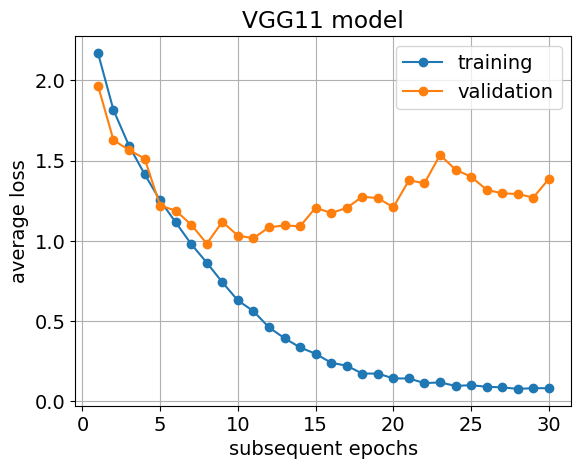

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VGG(make_layers(vgg_cfg['vgg11'])).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=model_args['lr'], 
                      momentum=.5,
                      weight_decay=1.e-3)
no_epochs = model_args['epochs']

train_loss_11, val_loss_11, best_accuracy = run_training(model, criterion, optimizer, no_epochs)

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy))
plot_loss(train_loss_11, val_loss_11, 'VGG11 model')

In [10]:
np.savetxt("VGG11.txt",[train_loss_11,val_loss_11])

In [11]:
torch.save(model.state_dict(), './VGG11_model.pth') 

Train Epoch: 1
	Train set: Average loss: 2.0753
	Validation set: Average loss: 1.8742, Accuracy: 1302/5000 (26%)
Train Epoch: 2
	Train set: Average loss: 1.7790
	Validation set: Average loss: 1.6921, Accuracy: 1568/5000 (31%)
Train Epoch: 3
	Train set: Average loss: 1.5876
	Validation set: Average loss: 1.4853, Accuracy: 2131/5000 (43%)
Train Epoch: 4
	Train set: Average loss: 1.4246
	Validation set: Average loss: 1.2923, Accuracy: 2725/5000 (55%)
Train Epoch: 5
	Train set: Average loss: 1.2793
	Validation set: Average loss: 1.1795, Accuracy: 2832/5000 (57%)
Train Epoch: 6
	Train set: Average loss: 1.1740
	Validation set: Average loss: 1.2124, Accuracy: 2945/5000 (59%)
Train Epoch: 7
	Train set: Average loss: 1.0875
	Validation set: Average loss: 1.2287, Accuracy: 2975/5000 (60%)
Train Epoch: 8
	Train set: Average loss: 1.0122
	Validation set: Average loss: 1.1411, Accuracy: 3101/5000 (62%)
Train Epoch: 9
	Train set: Average loss: 0.9418
	Validation set: Average loss: 1.0946, Accuracy:

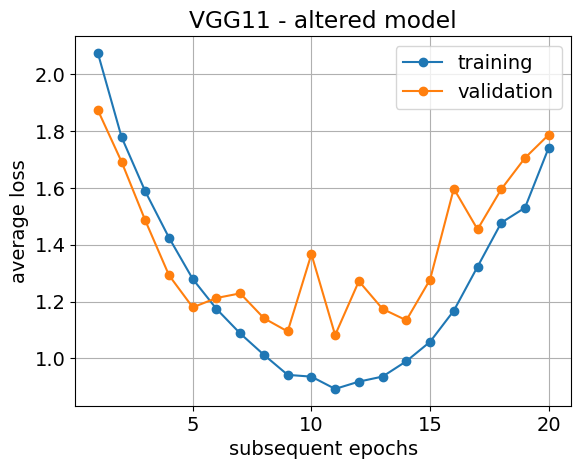

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VGG(make_layers(vgg_cfg['vgg11'])).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=model_args['lr'], 
                      momentum=.9,
                      weight_decay=0.)
no_epochs = model_args['epochs']

train_loss_11, val_loss_11, best_accuracy = run_training(model, criterion, optimizer, no_epochs)

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy))
plot_loss(train_loss_11, val_loss_11, 'VGG11 - altered model')

In [26]:
np.savetxt("VGG11_v2.txt",[train_loss_11,val_loss_11])

In [27]:
torch.save(model.state_dict(), './VGG11_v2_model.pth') 

Train Epoch: 1
	Train set: Average loss: 2.1227
	Validation set: Average loss: 2.0542, Accuracy: 907/5000 (18%)
Train Epoch: 2
	Train set: Average loss: 1.9587
	Validation set: Average loss: 1.8937, Accuracy: 1120/5000 (22%)
Train Epoch: 3
	Train set: Average loss: 1.8839
	Validation set: Average loss: 1.8983, Accuracy: 1158/5000 (23%)
Train Epoch: 4
	Train set: Average loss: 1.8429
	Validation set: Average loss: 1.7932, Accuracy: 1283/5000 (26%)
Train Epoch: 5
	Train set: Average loss: 1.8160
	Validation set: Average loss: 1.7757, Accuracy: 1469/5000 (29%)
Train Epoch: 6
	Train set: Average loss: 1.7454
	Validation set: Average loss: 1.6716, Accuracy: 1530/5000 (31%)
Train Epoch: 7
	Train set: Average loss: 1.6544
	Validation set: Average loss: 1.6572, Accuracy: 1542/5000 (31%)
Train Epoch: 8
	Train set: Average loss: 1.5628
	Validation set: Average loss: 1.5006, Accuracy: 2043/5000 (41%)
Train Epoch: 9
	Train set: Average loss: 1.4907
	Validation set: Average loss: 1.5271, Accuracy: 

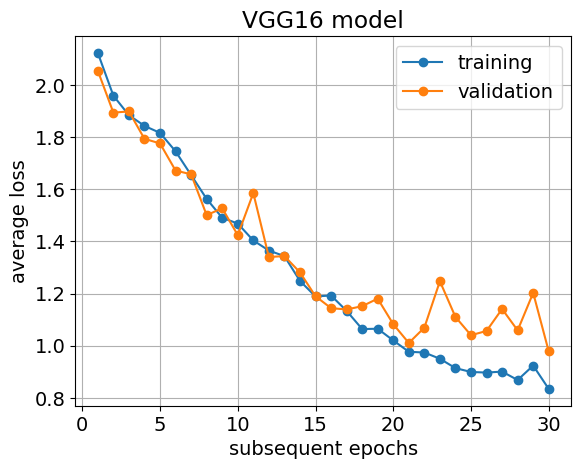

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VGG(make_layers(vgg_cfg['vgg16'])).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=model_args['lr'], 
                      momentum=model_args['momentum'],
                      weight_decay=1.e-3)

no_epochs = model_args['epochs']

train_loss_16, val_loss_16, best_accuracy = run_training(model, criterion, optimizer, no_epochs)

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy))
plot_loss(train_loss_16, val_loss_16, 'VGG16 model')

In [16]:
np.savetxt("VGG16.txt",[train_loss_16,val_loss_16])

In [17]:
torch.save(model.state_dict(), './VGG16_model.pth') 

Train Epoch: 1
	Train set: Average loss: 2.2961
	Validation set: Average loss: 2.3065, Accuracy: 446/5000 (9%)
Train Epoch: 2
	Train set: Average loss: 2.3047
	Validation set: Average loss: 2.3069, Accuracy: 486/5000 (10%)
Train Epoch: 3
	Train set: Average loss: 2.3046
	Validation set: Average loss: 2.3043, Accuracy: 478/5000 (10%)
Train Epoch: 4
	Train set: Average loss: 2.3043
	Validation set: Average loss: 2.3046, Accuracy: 498/5000 (10%)
Train Epoch: 5
	Train set: Average loss: 2.3042
	Validation set: Average loss: 2.3044, Accuracy: 446/5000 (9%)
Train Epoch: 6
	Train set: Average loss: 2.3045
	Validation set: Average loss: 2.3037, Accuracy: 522/5000 (10%)
Train Epoch: 7
	Train set: Average loss: 2.3045
	Validation set: Average loss: 2.3024, Accuracy: 522/5000 (10%)
Train Epoch: 8
	Train set: Average loss: 2.3040
	Validation set: Average loss: 2.3059, Accuracy: 496/5000 (10%)
Train Epoch: 9
	Train set: Average loss: 2.3046
	Validation set: Average loss: 2.3036, Accuracy: 515/5000 

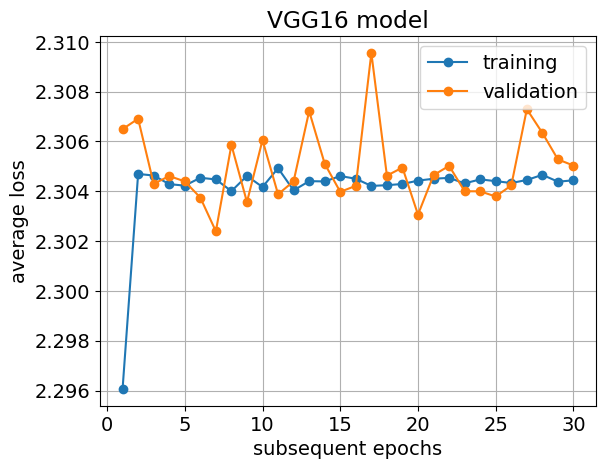

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VGG(make_layers(vgg_cfg['vgg19'])).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=model_args['lr'], 
                      momentum=model_args['momentum'],
                      weight_decay=1.e-3)

no_epochs = model_args['epochs']

train_loss_19, val_loss_19, best_accuracy = run_training(model, criterion, optimizer, no_epochs)

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy))
plot_loss(train_loss_19, val_loss_19, 'VGG19 model')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [19]:
np.savetxt("VGG19.txt",[train_loss_19,val_loss_19])

In [20]:
torch.save(model.state_dict(), './VGG19_model.pth') 

Train Epoch: 1
	Train set: Average loss: 2.2770
	Validation set: Average loss: 2.3757, Accuracy: 478/5000 (10%)
Train Epoch: 2
	Train set: Average loss: 2.3055
	Validation set: Average loss: 2.3035, Accuracy: 515/5000 (10%)
Train Epoch: 3
	Train set: Average loss: 2.3046
	Validation set: Average loss: 2.3049, Accuracy: 496/5000 (10%)
Train Epoch: 4
	Train set: Average loss: 2.3047
	Validation set: Average loss: 2.3040, Accuracy: 500/5000 (10%)
Train Epoch: 5
	Train set: Average loss: 2.3044
	Validation set: Average loss: 2.3031, Accuracy: 522/5000 (10%)
Train Epoch: 6
	Train set: Average loss: 2.3040
	Validation set: Average loss: 2.3053, Accuracy: 500/5000 (10%)
Train Epoch: 7
	Train set: Average loss: 2.3043
	Validation set: Average loss: 2.3042, Accuracy: 515/5000 (10%)
Train Epoch: 8
	Train set: Average loss: 2.3048
	Validation set: Average loss: 2.3025, Accuracy: 496/5000 (10%)
Train Epoch: 9
	Train set: Average loss: 2.3047
	Validation set: Average loss: 2.3048, Accuracy: 500/500

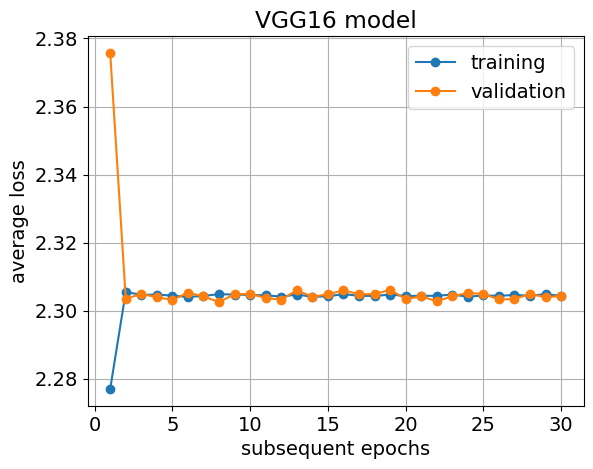

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VGG(make_layers(vgg_cfg['vgg22'])).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=model_args['lr'], 
                      momentum=model_args['momentum'],
                      weight_decay=1.e-3)

no_epochs = model_args['epochs']

train_loss_22, val_loss_22, best_accuracy = run_training(model, criterion, optimizer, no_epochs)

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy))
plot_loss(train_loss_22, val_loss_22, 'VGG16 model')

In [22]:
np.savetxt("VGG22.txt",[train_loss_22,val_loss_22])

In [23]:
torch.save(model.state_dict(), './VGG22_model.pth') 

Now compare training curves for both VGGs:

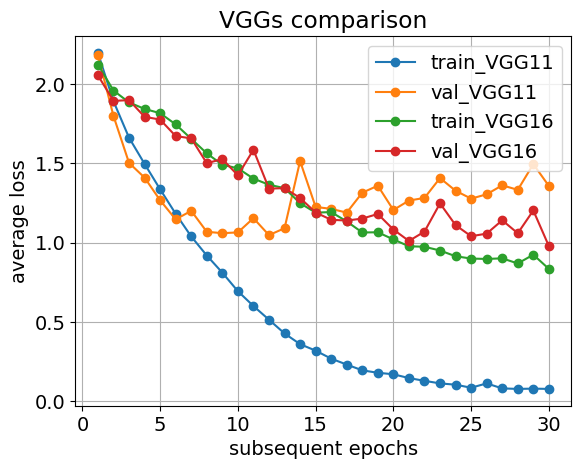

In [24]:
plt.grid(True)
plt.xlabel("subsequent epochs")
plt.ylabel('average loss')
plt.plot(range(1, len(train_loss_11)+1), train_loss_11, 'o-', label='train_VGG11')
plt.plot(range(1, len(val_loss_11)+1), val_loss_11, 'o-', label='val_VGG11')
plt.plot(range(1, len(train_loss_16)+1), train_loss_16, 'o-', label='train_VGG16')
plt.plot(range(1, len(val_loss_16)+1), val_loss_16, 'o-', label='val_VGG16')
plt.legend()
plt.title("VGGs comparison")
plt.show()

Let's check residual network: ResNet
- implementarion borrowed from https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=model_args['lr'], 
                      momentum=model_args['momentum'],
                      weight_decay=1.e-3)

no_epochs = model_args['epochs']

train_loss, validation_loss, best_accuracy = run_training(model, criterion, optimizer, no_epochs)

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy))
plot_loss(train_loss, validation_loss, 'ResNet18 model')

In [ ]:
np.savetxt("ResNet18.txt",[train_loss,val_loss])

In [ ]:
torch.save(model.state_dict(), './ResNet18_model.pth') 

Now let's play with **transfer learning**. Compare our results with Resnet18 from *Torchvision* package with pretrained weights (i.e. pretrained=True)
* pretrained model needs to be tuned (to be comparable with previous one)

In [ ]:
import torchvision.models.resnet as resnet
model = resnet.resnet18(pretrained=True)
print(model)
model.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
model.bn1 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
model.relu = nn.Identity()  # only input layers
model.maxpool = nn.Identity()  # only in input layers
model.fc = nn.Linear(512, 10)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=model_args['lr'], 
                      momentum=model_args['momentum'],
                      weight_decay=1.e-3)

no_epochs = model_args['epochs']

train_loss, validation_loss, best_accuracy = run_training(model, criterion, optimizer, no_epochs)

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy))
plot_loss(train_loss, validation_loss, 'ResNet18 pretrained model')

## Tasks to do:

1. Check turning off the data normalization -- how this impacts network training.
2. What happens if we put *weight_decay* = 0. and increase *momentum* to .9 for VGG11 model -- why is that? (hint: observe interplay between *learning rate* and *momentum*)
3. Try to explain why the deeper VGG16 network trains longer than VGG11.
4. Compare with performance for deeper VGGs: 19 or 22 -- do we observe saturation in accuracy or even *degradation* problem?
5. Does ResNet18 (with similar depth) perform better, what for ResNet34? What about training time in this case?
6. Does transfer learning speed up training?

---

## Additional comments/tasks
In some situations (especially when training large models), it can be useful to save the trained model (its parameters) for future evaluation. A common method is to save the model after each epoch, and then use the one with the lowest validation error.<br>
To save/load model parameters, we can use:
```python
torch.save(model.state_dict(), './model.pth') 
```
then later
```python
model = TheModelClass()
model.load_state_dict(torch.load('./model.pth'))
model.eval()
```

Having model's parameters can be used to visualize conv layer kernels. We can access each model parameter through:
```python
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)
```
or just print out given layer, e.g. in *SimpleCNN*, we can acces to its kernels via:
```python
print(conv1.weight)
```
- try to visualize them
- how many different kernels do we have in a given layer, why is that?


To analyze the model structure *torch-summary* package can be usefull:


In [ ]:
from torchsummary import summary

model = SimpleCNN().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 80]           9,680
            Linear-7                   [-1, 10]             810
Total params: 61,482
Trainable params: 61,482
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.23
Estimated Total Size (MB): 0.31
----------------------------------------------------------------
